# Table of Contents

- [Project Overview](#project-overview)
- [Dataset Description](#dataset-description)
- [Import Libraries](#import-libraries)
- [Load Data](#load-data)
- [Data Cleaning](#data-cleaning)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Feature Engineering](#feature-engineering)
- [Model Training and Evaluation](#model-training-and-evaluation)
- [Results and Analysis](#results-and-analysis)
- [Silhouette Analysis](#silhouette-analysis)
- [Conclusion and Future Work](#conclusion-and-future-work)
- [References](#references)

---

# UR3 CobotOps: Unsupervised Behaviors Clustering
 
## Project Overview
UR3 CobotOps is a dataset that contains time-series data from a collaborative robot (cobot) performing various tasks. The dataset includes sensor readings, joint positions, and other relevant information that can be used for analysis and modeling.  
__I want to perform clustering analysis on this dataset to identify different operational behaviors of the cobot.__  

## Dataset Description
The dataset is available on [UR3 CobotOps. UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/963/ur3+cobotops).   
It is provided as tabulated data in CSV format. It consists of one CSV files with 7409 instances and 22 features with continuous, categorical and real variables. Some instances have missing values.  
The features include various sensor readings and operational parameters of the cobot, such as:  
- Time stamps 
- Electrical currents
- Temperatures
- Speeds across joints (J0-J5)
- Gripper current
- Operation cycle count
- Protective stops
- Grip losses

# Import Libraries

In [91]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
from pathlib import Path
from math import ceil

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Load Data 
We can see that there are 7409 rows and 29 columns in the dataset. Some columns with missing value in all rows, which we need to remove the columns. Some columns have missing values, which we will need to handle during data cleaning.

In [92]:
DATA_PATH = Path('ur3_cobotops.csv')
df = pd.read_csv(DATA_PATH)
print('data shape :', df.shape)
df.head()

data shape : (7409, 29)


,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,1,2022-10-26T08:17:21.847Z,0.109628,27.875,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,...,-0.152962,0.082732,1,False,False,NaN,NaN,NaN,NaN,NaN
1,2,2022-10-26T08:17:22.852Z,0.595605,27.875,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,...,0.000417,0.505895,1,False,False,NaN,NaN,NaN,NaN,NaN
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.875,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,...,-0.496856,0.079420,1,False,False,NaN,NaN,NaN,NaN,NaN
3,4,2022-10-26T08:17:24.863Z,0.065053,27.875,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,...,0.425559,0.083325,1,False,False,NaN,NaN,NaN,NaN,NaN
4,5,2022-10-26T08:17:25.877Z,0.884140,27.875,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,...,0.180989,0.086379,1,False,False,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
- Drop unnecessary column - Num
- Drop columns that all nan
- Replace space in column name
- Drop Timestamp column because it is not useful for this clustering analysis

- 'Robot_ProtectiveStop' and 'grip_lost' are binary value, it's better to convert it to int 
- Check nan value in cycle and drop the rows with nan cycle value
- Use mean instead of nan value in other columns which has continuous column type

__After cleaning, we have 7409 rows and 22 columns without nan value in the cleaned dataset .__


In [93]:
nan_counts = df.isna().sum()
nan_counts_sum = nan_counts.sum()
print(f'Check nan count before cleaning : {nan_counts_sum}')
print('\n')

df_cleaning = df
df_cleaning = df_cleaning.drop('Num', axis=1)
df_cleaning = df_cleaning.dropna(axis=1, how='all')
df_cleaning.columns = [c.strip().replace(' ', '_') for c in df_cleaning.columns]
df_cleaning = df_cleaning.drop('Timestamp', axis=1)

# covert binary to int and fill nan with 0
binary_cols = ['Robot_ProtectiveStop', 'grip_lost']
for c in binary_cols:
    if c in df_cleaning.columns:
        df_cleaning[c] = pd.to_numeric(df_cleaning[c], errors='coerce').fillna(0).astype(int)

# check cycle and fill nan with -1 
df_cleaning['cycle'] = pd.to_numeric(df_cleaning['cycle'], errors='coerce').fillna(-1).astype(int)
df_cleaning = df_cleaning[df_cleaning['cycle'] >= 0]

exclude = ['cycle'] + binary_cols
continuous_cols = [c for c in df_cleaning.columns if c not in exclude and np.issubdtype(df_cleaning[c].dtype, np.number)]

# check other columns and fill nan with mean
df_cleaning[continuous_cols] = df_cleaning.groupby('cycle')[continuous_cols].transform(lambda s: s.fillna(s.median()))
df_cleaning[continuous_cols] = df_cleaning[continuous_cols].fillna(df_cleaning[continuous_cols].median())

print('Data shape after data cleaning :', df_cleaning.shape)
df_cleaning.head()

nan_counts = df_cleaning.isna().sum()
nan_counts_sum = nan_counts.sum()
print(f'Check nan count after cleaning : {nan_counts_sum}')
print(nan_counts)

Check nan count before cleaning : 38117


Data shape after data cleaning : (7409, 22)
Check nan count after cleaning : 0
Current_J0              0
Temperature_T0          0
Current_J1              0
Temperature_J1          0
Current_J2              0
Temperature_J2          0
Current_J3              0
Temperature_J3          0
Current_J4              0
Temperature_J4          0
Current_J5              0
Temperature_J5          0
Speed_J0                0
Speed_J1                0
Speed_J2                0
Speed_J3                0
Speed_J4                0
Speed_J5                0
Tool_current            0
cycle                   0
Robot_ProtectiveStop    0
grip_lost               0
dtype: int64


# Explorory Data Analysis
- Visualize sensor distribution  
We can see that most of the sensor readings aren't normally distributed, which showing greatly skewness. This indicates that the data may be clustered into distinct groups based on the sensor readings.  

- Visualize cycle distribution  
We can see that the cycle distribution is average, with some cycles having higher values. This indicates that the cobot operates more frequently in higher cycle ranges, with occasional lower cycle operations.  

- Correlation matrix with heat map  
We can see that there are some strong correlations between certain features, such as temperature between the joint positions. And some speed in the specific joint positions also strong correlated between each other. This suggests that these features may be related and could potentially be used together in clustering analysis.  


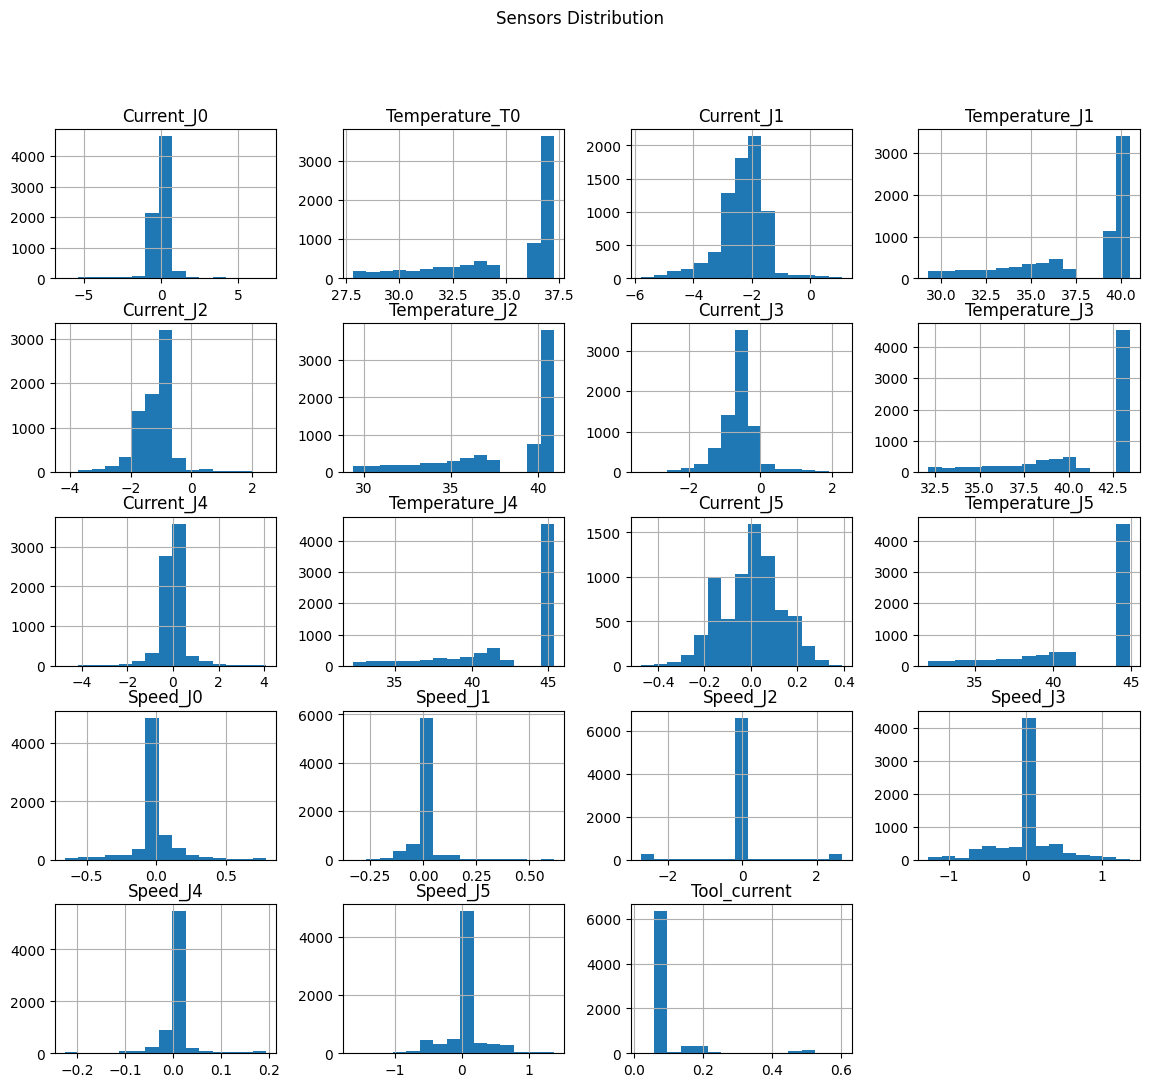

In [94]:
df_cleaning[continuous_cols].hist(bins=15, figsize=(14,12))
plt.suptitle('Sensors Distribution')
plt.show()

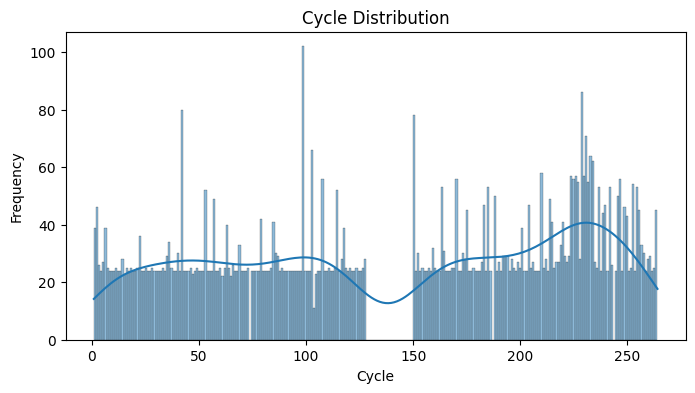

In [95]:
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaning['cycle'], bins=265, kde=True)
plt.title('Cycle Distribution')
plt.xlabel('Cycle')
plt.ylabel('Frequency')
plt.show()

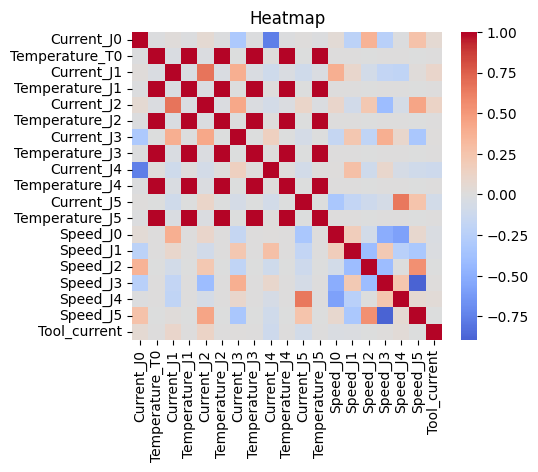

In [96]:
corr = df_cleaning[continuous_cols].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Heatmap')
plt.show()

# Feature Engineering
To prepare the data for clustering analysis, I performed feature engineering to extract relevant features (mean, std, min, max, madiff, p01, p99) from the time-series data.
Then, I performed PCA to reduce the dimensionality of the dataset and identify the most important features for clustering analysis.  
- Summarize the time-series data to create cycle-level features  
- Standardize the data(cycle-level features) using StandardScaler  
- Perform PCA and determine the number of components to retain based on explained variance ratio  
- Transform the data using the selected number of components  

__I decided to retain 27 components based on the explained variance ratio, which captures 95% of the variance in the data.__

In [97]:
def summarize_series(x, sampling_rate=1.0):
    arr = pd.to_numeric(x, errors='coerce').dropna().values
    if arr.size < 2:
        # default value
        return pd.Series({
            'mean':0, 'std':0, 'min':0, 'max':0, 'madiff':0, 'p01':0, 'p99':0
        })

    # time-frequency
    res = {
        'mean': np.mean(arr),
        'std': np.std(arr),
        'min': np.min(arr),
        'max': np.max(arr),
        'madiff': np.mean(np.abs(np.diff(arr))),
        'p01': np.percentile(arr, 1),
        'p99': np.percentile(arr, 99)
    }

    return pd.Series(res)

features = []
for c in continuous_cols:
    tmp = df_cleaning.groupby('cycle').apply(lambda g: summarize_series(g[c]))
    if isinstance(tmp, pd.Series):
        tmp = tmp.unstack()
    tmp = tmp.add_prefix(f'{c}_')
    features.append(tmp)

print(f'Feature count : {len(features)}')
X_cycle = pd.concat(features, axis=1).sort_index()
X_cycle = X_cycle.replace([np.inf, -np.inf], np.nan).fillna(0)
print('Cycle-level feature shape:', X_cycle.shape)
print(f'Feature count : {len(X_cycle.columns)}')
print(f'Cycle count : {len(X_cycle)}')
X_cycle.head()

Feature count : 19
Cycle-level feature shape: (240, 133)
Feature count : 133
Cycle count : 240


,Current_J0_mean,Current_J0_std,Current_J0_min,Current_J0_max,Current_J0_madiff,Current_J0_p01,Current_J0_p99,Temperature_T0_mean,Temperature_T0_std,Temperature_T0_min,...,Speed_J5_madiff,Speed_J5_p01,Speed_J5_p99,Tool_current_mean,Tool_current_std,Tool_current_min,Tool_current_max,Tool_current_madiff,Tool_current_p01,Tool_current_p99
cycle,,,,,,,,,,,,,,,,,,,,,
1,-0.020017,0.323158,-0.888249,1.014086,0.271749,-0.703424,0.964707,27.900641,0.033844,27.8125,...,0.235932,-0.662654,0.656585,0.101410,0.068976,0.078827,0.505895,0.035735,0.079052,0.385213
2,-0.052927,0.230916,-0.616049,0.984271,0.174031,-0.516063,0.721205,28.021739,0.045552,27.9375,...,0.184426,-0.503546,0.905940,0.093418,0.037219,0.076280,0.305517,0.023034,0.076586,0.252162
3,0.035297,1.868010,-4.269836,6.460328,1.586797,-4.211124,5.734170,28.127404,0.027302,28.0625,...,0.297954,-0.584007,0.903685,0.095725,0.031267,0.079420,0.190770,0.026323,0.079611,0.189518
4,0.080079,0.696176,-1.997484,2.206317,0.718564,-1.611368,1.962686,28.208333,0.038976,28.1250,...,0.361313,-0.895883,0.680004,0.118797,0.087341,0.080865,0.501990,0.058427,0.081002,0.432459
5,-0.060776,0.776635,-3.548440,1.358701,0.625738,-2.708158,1.235492,28.291667,0.038036,28.1875,...,0.364587,-0.755037,0.975460,0.110564,0.079930,0.079420,0.481879,0.057252,0.079420,0.410362


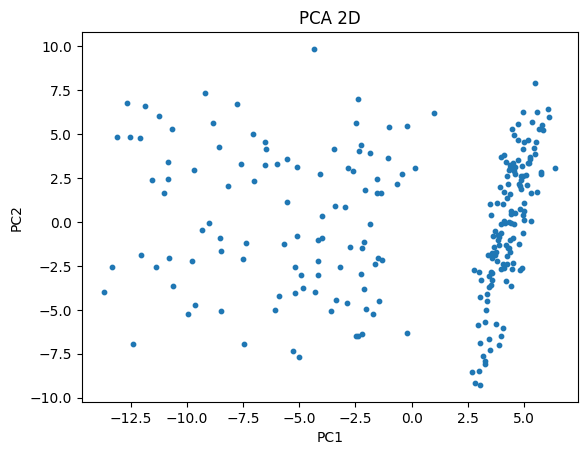

Dims needed for 95% variance: 27


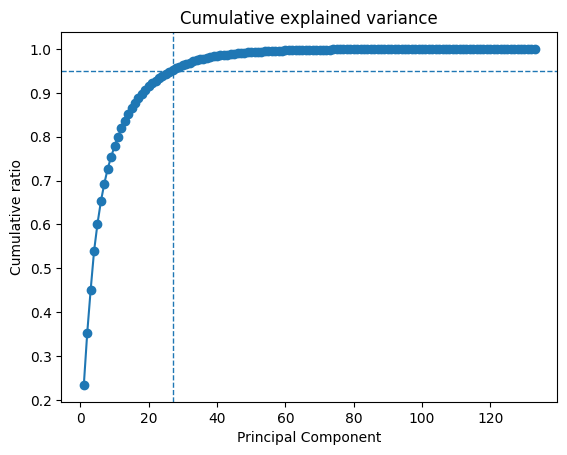

In [98]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cycle)

# for plot
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_for_plot = pca_2.fit_transform(X_scaled)
plt.scatter(X_for_plot[:,0], X_for_plot[:,1], s=10)
plt.title('PCA 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# get pca summarize
pca_full = PCA(random_state=RANDOM_STATE).fit(X_scaled)
evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

# set up threshold and get suggested n_components(k95)
threshold = 0.95
k95 = int(np.argmax(cum >= threshold) + 1)
print(f"Dims needed for {threshold*100:.0f}% variance:", k95)

pca = PCA(n_components=k95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
plt.plot(np.arange(1, len(cum)+1), cum, marker='o')
plt.axhline(threshold, ls='--', lw=1)
plt.axvline(k95, ls='--', lw=1)
plt.title('Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative ratio')
plt.show()



In [99]:
# significant feature in pca
loadings = pd.DataFrame(
    pca.components_.T,
    index=X_cycle.columns,
    columns=[f'PC{i+1}' for i in range(k95)]
)

evr = pca.explained_variance_ratio_         
L = loadings.values                           

overall_importance = (L**2 * evr).sum(axis=1)    # feature score
overall_rank = pd.Series(overall_importance, index=X_cycle.columns).sort_values(ascending=False)
overall_rank.head(k95)  

Temperature_J2_min     0.007516
Temperature_J2_p01     0.007516
Temperature_J2_mean    0.007516
Temperature_J2_p99     0.007515
Temperature_J2_max     0.007515
Temperature_J3_p01     0.007514
Temperature_J3_min     0.007514
Temperature_J3_mean    0.007514
Temperature_J3_p99     0.007513
Temperature_J3_max     0.007513
Temperature_J1_p01     0.007509
Temperature_J1_mean    0.007509
Temperature_J1_min     0.007509
Temperature_J1_p99     0.007508
Temperature_J1_max     0.007508
Temperature_J4_p99     0.007505
Temperature_J4_max     0.007505
Temperature_J4_mean    0.007505
Temperature_J4_p01     0.007505
Temperature_J4_min     0.007504
Temperature_J5_p01     0.007500
Temperature_J5_min     0.007500
Temperature_J5_mean    0.007498
Temperature_J5_p99     0.007497
Temperature_J5_max     0.007497
Temperature_T0_p01     0.007495
Temperature_T0_mean    0.007495
dtype: float64

In [100]:
evr = pca.explained_variance_ratio_
L2 = loadings**2
score = (L2 * evr).sum(axis=1).rename('score')
mod = pd.Series(
    np.select([
        score.index.str.startswith('Temperature_'),
        score.index.str.startswith('Speed_'),
        score.index.str.startswith('Current_'),
        score.index.str.contains('Tool_current')
    ], ['Temp','Speed','Current','Tool'], default='Other'),
    index=score.index, name='module'
)
print(score.groupby(mod).sum().sort_values(ascending=False))


module
Temp       0.305810
Speed      0.300008
Current    0.297063
Tool       0.049270
Name: score, dtype: float64


# Model Training and Evaluation
The goal of this project is to perform clustering analysis on the UR3 CobotOps dataset to identify different operational behaviors of the cobot.  

I compared the following clustering algorithms:
- KMeans
- GMM
- Agglomerative

For each algorithm, I tried different number of clusters (k) from 2 to 8 for __hypertuning__ and evaluated the performance using __silhouette score__ to score the clustering quality based on cohesion and separation within and between clusters.  

Afterwards, __I selected KMeans with cluster number 2 as the final model based on silhouette score (0.189810)__.

In [101]:
# evaluate function
def eval_internal(X, labels):
    try:
        sil = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
    except:
        sil, ch, db = np.nan, np.nan, np.nan
    return {'silhouette': sil, 'calinski_harabasz': ch, 'davies_bouldin': db}

results = []
labels_dict = {}

In [102]:
def run_model(model_name, k, X_pca, RANDOM_STATE):
    if model_name == 'KMeans':
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    elif model_name == 'GMM':
        model = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    elif model_name == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=k)
    else:
        raise ValueError("Unknown model")

    labels = model.fit_predict(X_pca)
    m = eval_internal(X_pca, labels)
    m['model'] = model_name
    m['k'] = k
    return (f'{model_name}_{k}', labels, m)

# tasks
tasks = [(model, k) for model in ['KMeans', 'GMM', 'Agglomerative']
         for k in range(2, 8)]

# parallelize
results_parallel = Parallel(n_jobs=-1)(
    delayed(run_model)(model, k, X_pca, RANDOM_STATE)
    for model, k in tqdm(tasks, desc="Running clustering models")
)

for name, labels, m in results_parallel:
    labels_dict[name] = labels
    results.append(m)

df_results = pd.DataFrame(results)
print(df_results)


Running clustering models: 100%|██████████| 18/18 [00:00<00:00, 1531.89it/s]

    silhouette  calinski_harabasz  davies_bouldin          model  k
0     0.189810          58.227805        1.905574         KMeans  2
1     0.124739          40.321350        2.324427         KMeans  3
2     0.127886          33.997095        2.100005         KMeans  4
3     0.111780          29.350513        2.316671         KMeans  5
4     0.103728          26.295910        2.241100         KMeans  6
5     0.105811          28.845089        1.889497         KMeans  7
6     0.159262          48.477562        2.117483            GMM  2
7     0.122811          39.425489        2.346288            GMM  3
8     0.124724          33.472228        2.106892            GMM  4
9     0.107449          28.922081        2.353403            GMM  5
10    0.103563          26.250342        2.246089            GMM  6
11    0.105143          28.794044        1.889192            GMM  7
12    0.181222          55.008963        1.956270  Agglomerative  2
13    0.184942          40.271942        1.35657

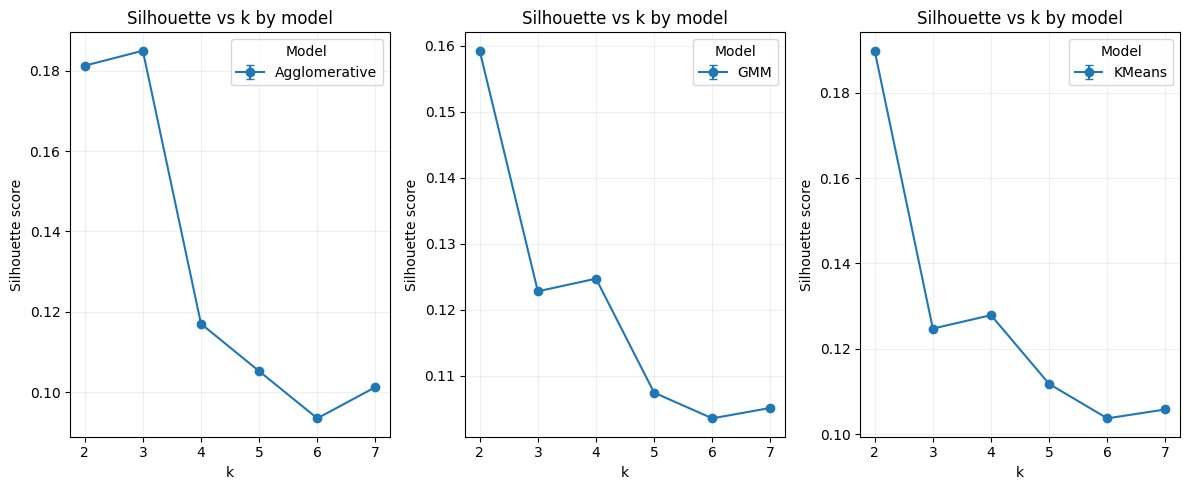

In [103]:
# visualize k-silhouette based on models
agg = (df_results
       .dropna(subset=['silhouette', 'k'])
       .groupby(['model','k'], as_index=False)
       .agg(sil_mean=('silhouette','mean'),
            sil_std=('silhouette','std'),
            n=('silhouette','size'))
       .sort_values(['model','k']))

plt.figure(figsize=(12, 5))
i = 1
for model, sub in agg.groupby('model'):
    x = sub['k'].values
    y = sub['sil_mean'].values
    yerr = sub['sil_std'].fillna(0).values
    plt.subplot(1, 3, i)
    plt.errorbar(x, y, yerr=yerr, marker='o', capsize=3, label=model)
    i = i + 1
    plt.xlabel('k'); plt.ylabel('Silhouette score')
    plt.title('Silhouette vs k by model')
    plt.xticks(sorted(agg['k'].unique()))
    plt.legend(title='Model')
    plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


We can see that the silhouette score for KMeans and Agglomerative are similar, while GMM has a lower silhouette score. This suggests that KMeans and Agglomerative may be better suited for clustering this dataset compared to GMM.

,silhouette,calinski_harabasz,davies_bouldin,model,k
0,0.189810,58.227805,1.905574,KMeans,2
13,0.184942,40.271942,1.356576,Agglomerative,3
6,0.159262,48.477562,2.117483,GMM,2


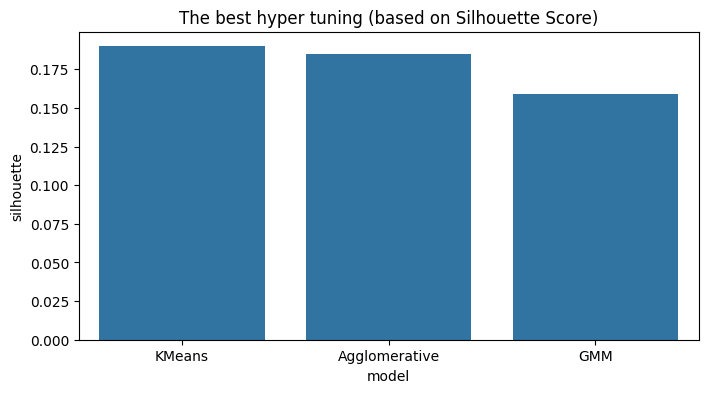

In [104]:
res_df = pd.DataFrame(results)
best_per_model = res_df.sort_values('silhouette', ascending=False).groupby('model').head(1)

display(best_per_model)

plt.figure(figsize=(8,4))
sns.barplot(x='model', y='silhouette', data=best_per_model)
plt.title('The best hyper tuning (based on Silhouette Score)')
plt.show()

,model,k,silhouette
0,Agglomerative,3,0.184942
1,GMM,2,0.159262
2,KMeans,2,0.189810


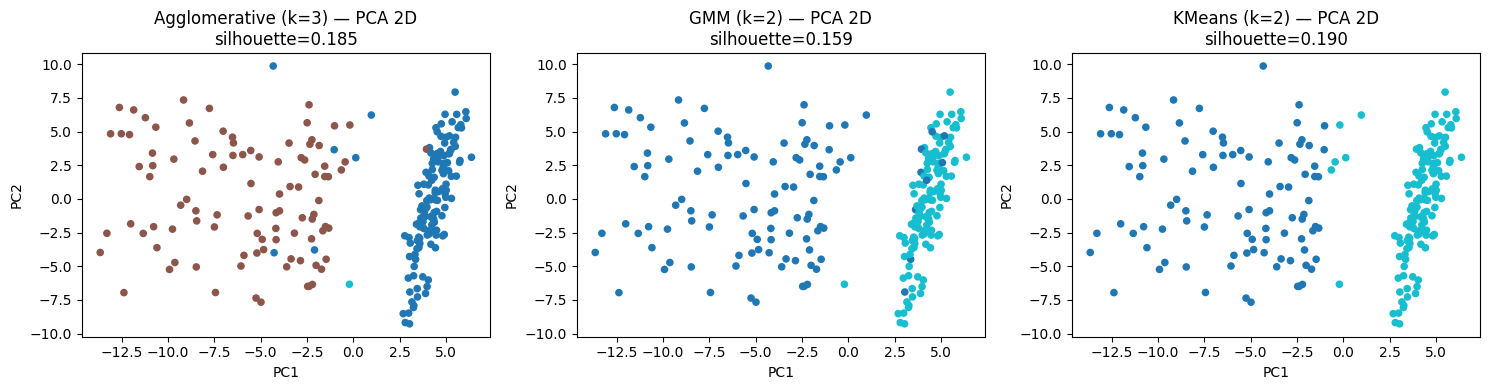

In [105]:
res_df = pd.DataFrame(results)
res_df = res_df.dropna(subset=['silhouette'])
# get the highest silhouette score
best_rows = res_df.sort_values('silhouette', ascending=False).groupby('model', as_index=False).first()

display(best_rows[['model','k','silhouette']])

models = list(best_rows['model'])
n = len(models)
ncols = 3
nrows = ceil(n / ncols)

plt.figure(figsize=(5*ncols, 4*nrows))

for i, row in enumerate(best_rows.itertuples(index=False), start=1):
    model = row.model
    # k is float from DataFrame => to int, if NaN(DBSCAN/IsolationForest) => None
    k = int(row.k) if pd.notna(row.k) else None
    sil = float(row.silhouette)

    # labels
    key = f"{model}_{k}" if k is not None else model
    if key not in labels_dict:
        # key name switch if there are other key name
        alt_keys = [kk for kk in labels_dict.keys() if kk.startswith(model)]
        if alt_keys:
            key = alt_keys[0]
        else:
            print(f"[warn] missing labels for {model} (k={k})")
            continue
    labels = labels_dict[key]

    plt.subplot(nrows, ncols, i)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20, cmap='tab10')
    title_k = f"k={k}" if k is not None else "k=-"
    plt.title(f"{model} ({title_k}) — PCA 2D\nsilhouette={sil:.3f}")
    plt.xlabel('PC1'); plt.ylabel('PC2')

plt.tight_layout()
plt.show()


# Results and Analysis
Based on the silhouette score, I selected KMeans with 2 clusters as the final model because it provided the best separation between operational behaviors, which __silhouette score__ of 0.18981 indicated.  
This model achieved an overall __sample silhouette score__ of 0.646, indicating good separation between clusters. I visualized the silhouette scores for each cluster and found that both clusters had positive silhouette scores, indicating that the samples were well clustered. 

In [106]:
best_model = 'KMeans'
K = 2
labels_best_model = labels_dict[f'{best_model}_{K}']

The PCA 2D projection shows a clear split primarily along PC1. Points on the right form a narrow, compact band (cluster 1), while points on the left are more dispersed (cluster 0). This indicates PC1 dominates the separation, which—consistent with PCA loadings—is likely driven by temperature-related features (overall thermal level).

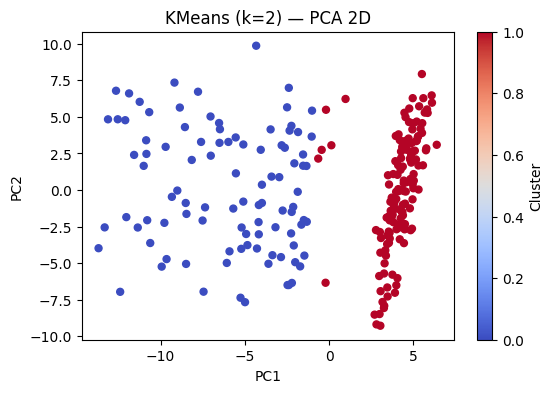

In [107]:
plt.figure(figsize=(6,4))
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels_best_model, cmap='coolwarm', s=25
)
plt.title(f'{best_model} (k={K}) — PCA 2D')
plt.xlabel('PC1')
plt.ylabel('PC2'); plt.colorbar(label='Cluster')
plt.show()

# Silhouette Analysis
I also computed the silhouette scores to evaluate the clustering quality:  
Overall silhouette = 0.646 shows that there is good separation between clusters, and they are reasonably compact and well separated.  

For Cluster 1: higher mean (~0.78) shows a tight, well-defined cluster.  
For Cluster 0: lower mean (~0.46) with a smaller minimum (slightly negative) shows looser boundaries with a few borderline samples.   
Counts (142 vs. 98) show moderate class imbalance, but both clusters are substantial.   



The silhouette plot indicates overall good separation (most samples > 0). Cluster 1 has consistently higher silhouette values (tight, well‐defined), whereas cluster 0 shows a wider spread with some near-zero values (looser boundaries / mild overlap).

0     98
1    142
Name: count, dtype: int64
Overall silhouette: 0.646


,count,mean,median,min,max
cluster,,,,,
0,98,0.457160,0.560320,-0.215361,0.648999
1,142,0.776697,0.804766,0.066250,0.842535


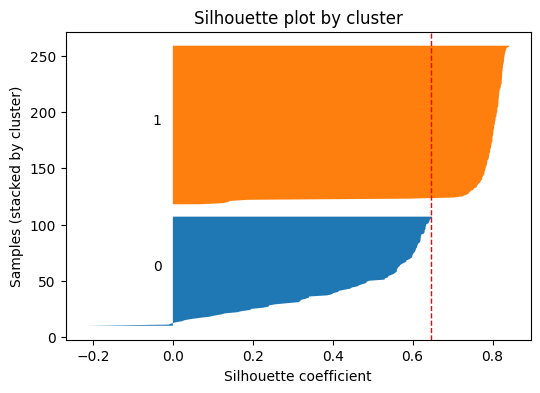

In [108]:
cluster_count = pd.Series(labels_best_model).value_counts().sort_index().rename('count')
print(cluster_count)

labels = np.asarray(labels_best_model)
sil_overall = silhouette_score(X_cycle, labels)
sil_each = silhouette_samples(X_cycle, labels)

df_sil = pd.DataFrame({'cluster': labels, 'silhouette': sil_each})
summary = df_sil.groupby('cluster')['silhouette'].agg(['count','mean','median','min','max']).sort_index()

print(f'Overall silhouette: {sil_overall:.3f}')
display(summary)

# silhouette distribution base on clusters
y_lower = 10
plt.figure(figsize=(6,4))
for k in range(K):
    vals = np.sort(sil_each[labels_best_model==k])
    size = vals.shape[0]
    y_upper = y_lower + size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, vals)
    plt.text(-0.05, y_lower + 0.5*size, str(k))
    y_lower = y_upper + 10
plt.axvline(sil_overall, color='red', ls='--', lw=1)
plt.xlabel('Silhouette coefficient')
plt.ylabel('Samples (stacked by cluster)')
plt.title('Silhouette plot by cluster')
plt.show()


The heatmap of the top 27 PCA-important features shows systematic differences: cluster 0 exhibits higher values across temperature statistics, while cluster 1 shows lower values. This suggests two operation modes aligned with high-temperature vs low-temperature states.

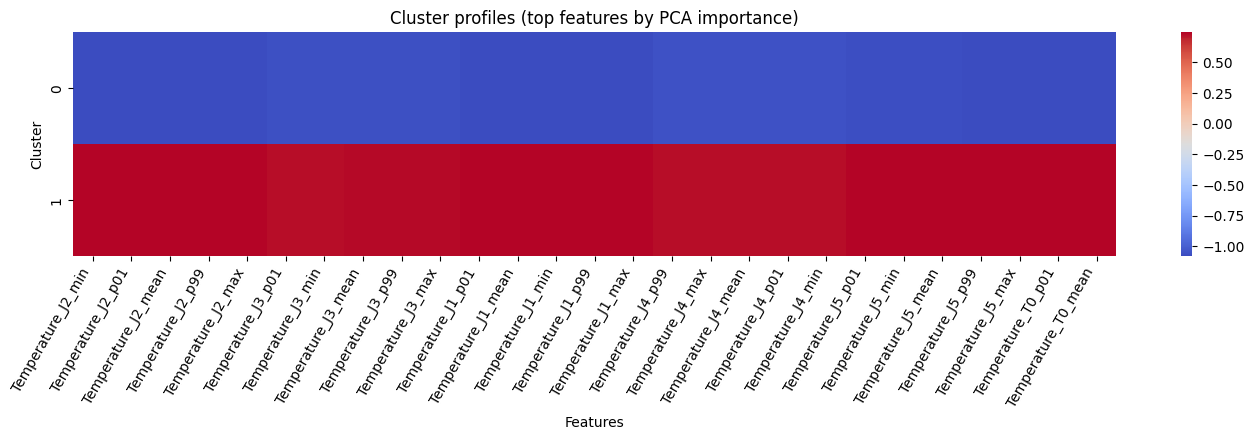

In [109]:
labels = pd.Series(labels_best_model, index=X_cycle.index, name='cluster')

loadings = pd.DataFrame(
    pca.components_.T,              # shape: (n_features, n_keep)
    index=X_cycle.columns,
    columns=[f'PC{i+1}' for i in range(27)]
)
evr = pca.explained_variance_ratio_        # length n_keep
overall_importance = (loadings.values**2 * evr).sum(axis=1)
imp_series = pd.Series(overall_importance, index=X_cycle.columns).sort_values(ascending=False)

top_feats = imp_series.head(27).index.tolist()

# z-score
Xz = (X_cycle - X_cycle.mean()) / X_cycle.std(ddof=0)
profiles = Xz.groupby(labels).mean().loc[[c for c in [0,1] if c in labels.unique()], top_feats]

plt.figure(figsize=(14, 4 + 0.25*len(profiles)))
sns.heatmap(
    profiles,
    cmap='coolwarm', 
    cbar=True,
    annot=False
)
plt.title('Cluster profiles (top features by PCA importance)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


# Conclusion and Future Work
In this project, I performed unsupervised clustering on cycle-level features from the UR3 CobotOps dataset. After, feature engineering, standardization and PCA, I used the top-k PCs that preserve 95% of variance(n_component=27) for training.  
<div align='center'>

| model             | k              | silhouette |
|-------------------|----------------|------------|
| Agglomerative     | 3              | 0.184942   |
| GMM               | 2              | 0.159262   |
| KMeans            | 2              | 0.189810   |

</div>

And I compared KMeans, GMM, and Agglomerative clustering algorithms with different cluster numbers (k=2 to 8) using silhouette score for evaluation. Among all tested configurations, __The best model was KMeans(k=2)achieved a silhouette = 0.189810, indicating clear separation__.

In the PCA-2D projection, clusters split mainly along PC1, whose loadings are dominated by temperature statistics, suggesting two operational modes that align with temperature states.  
<div align='center'>

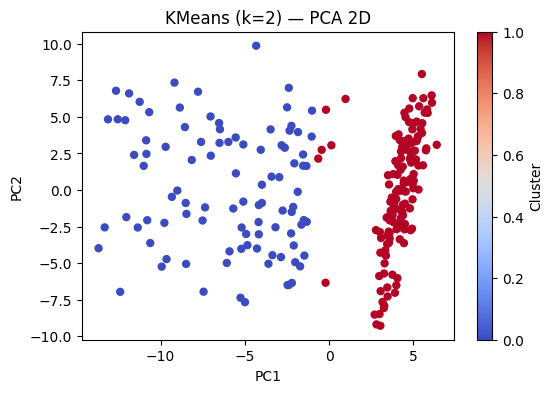
</div>

The silhouette analysis shows that both clusters are reasonably well-defined, with cluster 1 being more compact and cluster 0 having looser boundaries. Overall, the silhouette scores indicate good clustering quality.
<div align='center'>

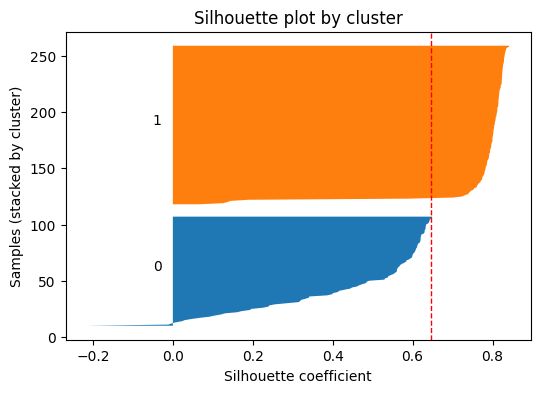
</div>

The cluster-profile heatmap confirms systematically related temperature features in Cluster 0 and non-related temperature features in Cluster 1, consistent with different thermal regimes during operation.   
<div align='center'>

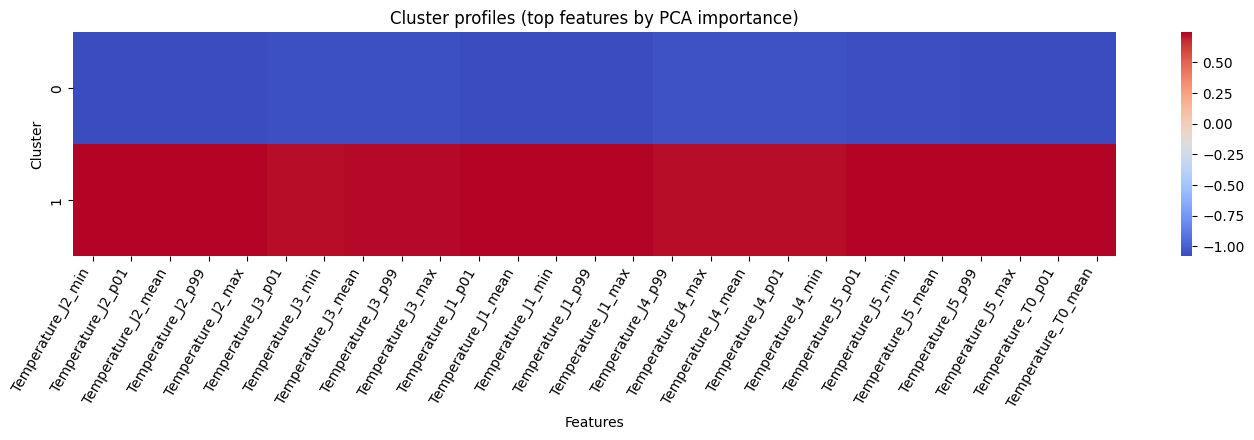

</div>

Future work could involve exploring additional data preprocessing techniques, such as advanced feature extraction, like frequency features, fft, wavelet transform, etc., to capture more complex patterns in the time-series data.  

Additionally, further validation of the clusters using external metrics or expert evaluation would also enhance the robustness of the findings. Finally, we might consider applying expert labeling for semi-supervised learning or anomaly detection to identify unusual operational behaviors. 

# References
- [UR3 CobotOps. UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/963/ur3+cobotops)
- [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)